# How cool is cucumber? Experiments with word embedding

We all know old, good and hackneyed examples, that are typically used to intuitively explain, what the **word embedding** technique is. We almost always come across a chart presenting a simplified, 2-dimensional vector representation of words **queen** and **king**, which are distant from each other in the similar length as words **woman** and **man**. 

One of the most convenient ways to get **embedding vectors** for natural language is to use pre-trained models distributed with [**spacy**](https://spacy.io/) library.

In [1]:
import numpy as np
import numpy.typing as npt
import spacy
import matplotlib.pyplot as plt

In [2]:
# Installing en_core_web_mdn
nlp = spacy.load('en_core_web_md')

In [3]:
fire = nlp('fire')
ice = nlp('ice')

In [4]:
len(fire.vector)

300

A couple of simple function calls, but there is a lot work done behind the scene. In fact, we can use **nlp** object to process whole sentences (or documents) at once. For now, we only need to process single words.

## Math behind

### Adding a new axis

The experiment I'd like to conduct is to "draw" a straight line in n-dimensional space and treat it as a new axis. It's possible if we project the considered points on this line.

### Line in n-dimensional space

First of all, we find an equation of a line generalized to n-dimensional space. Such straight line can be unambiguously determined using a point lying on this line and so-called **direction vector**.

<center>
$\vec{d} = (l, m, n, ...)$
</center>

Given the points $A = (x, y, z)$ and $B = (x_{1}, y_{1}, z_{1})$, it's simply computed as a elementwise difference between these two points, namely:

<center>
$ \vec{d} = A - B = (x, y, z, ...) - (x_{1}, y_{1}, z_{1}, ...) $
</center>

In our case, it can be defined as follows:

In [5]:
direction = fire.vector - ice.vector

Complete equation:

<center>
$ \frac{x - x_{1}}{l}  = \frac{y - y_{1}}{m} = \frac{z - z_{1}}{n} =   \ ...$
</center>



We also will use a **midpoint** between two initial points as beginining of our new axis.
It can be calculated with the following formula:

<center>
$  M = (\frac{x + x_{1}}{2}, \frac{y + y_{1}}{2}, \frac{z + z_{1}}{2}, ...) $
</center>

Writing that as a function:

In [7]:
def midpoint(x: npt.NDArray, y: npt.NDArray) -> npt.NDArray:
    if (len(x) != len(y)):
        raise ValueError(
            f'Vectors come from different spaces! ' + 
            f'x: {len(x)} dimensions, y: {len(y)} dimensions')
    return (x + y) / 2

In [8]:
# midpoint(np.array([2, 3]), np.array([-1, 20]))
# midpoint(np.array([2, 3]), np.array([-1, 20, -45]))

In [9]:
mid = midpoint(fire.vector, ice.vector)

Two values that we need for the moment:
* ```mid```
* ```direction```

### Let's draw it 

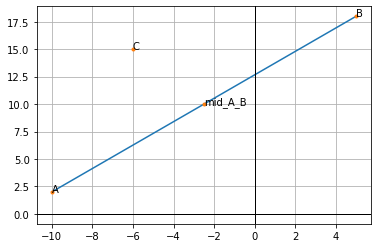

In [11]:
# Points lying on the straight line
a = np.array([-10, 2])
b = np.array([5, 18]) # 18

# a = np.array([2, 2])
# b = np.array([-2, -2])

mid_a_b = midpoint(a, b)

c = np.array([-6, 15])
#c = np.array([2, 15])

points = [a, b, mid_a_b, c]
labels = ['A', 'B', 'mid_A_B', 'C']

points_x = [x[0] for x in points]
points_y = [x[1] for x in points]


plt.plot([a[0], b[0]], [a[1], b[1]])

for coords, lbl in zip(points, labels):
    plt.text(coords[0], coords[1], lbl)

plt.plot(points_x, points_y, '.')
# Line
plt.grid()
plt.axhline(linewidth=1, color='black')
plt.axvline(linewidth=1, color='black')
plt.show()

As we can see, the line doesn't pass trough the origin. It means we cannot simply project C point using the **dot product** operation. First, we have to apply **affine transformation** to shift the whole space.

In [12]:
affine_transform_matrix = np.eye(3)
affine_transform_matrix[0:2, -1] = -mid_a_b
affine_transform_matrix

array([[  1. ,   0. ,   2.5],
       [  0. ,   1. , -10. ],
       [  0. ,   0. ,   1. ]])

In [13]:
# tranformed_a = affine_transform_matrix @ np.vstack(a.T, [1])
def extend_with_one(vec):
    vec = vec[np.newaxis].T
    return np.vstack([vec, [1]])  

transposed_vecs = [extend_with_one(p) for p in points]
transformed_vecs = [affine_transform_matrix @ vec for vec in transposed_vecs]

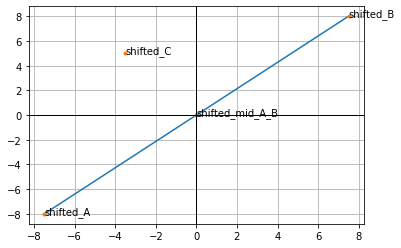

In [28]:
points = transformed_vecs
labels = ['shifted_A', 'shifted_B', 'shifted_mid_A_B', 'shifted_C']

points_x = [x[0] for x in points]
points_y = [x[1] for x in points]

aff_a, aff_b, aff_mid_a_b, aff_c = transformed_vecs

plt.plot([aff_a[0], aff_b[0]], [aff_a[1], aff_b[1]])

for coords, lbl in zip(points, labels):
    plt.text(coords[0], coords[1], lbl)

plt.plot(points_x, points_y, '.')
# Line
plt.grid()
plt.axhline(linewidth=1, color='black')
plt.axvline(linewidth=1, color='black')
plt.show()

In [29]:
## Projection
# https://en.wikibooks.org/wiki/Linear_Algebra/Orthogonal_Projection_Onto_a_Line
# https://www.youtube.com/watch?v=Ce1CP30Oa4w
# http://faculty.salina.k-state.edu/tim/DAT/linAlg/projection/projectR2.html

In [30]:
aff_mid_a_b, aff_b, aff_c = aff_mid_a_b[0:2], aff_b[0:2], aff_c[0:2]
dir_vec = (aff_b) / np.linalg.norm(aff_b)

proj_c = (aff_c.T @ dir_vec) / (dir_vec.T @ dir_vec) * dir_vec

dir_vec
proj_c

array([[0.85758836],
       [0.91476091]])

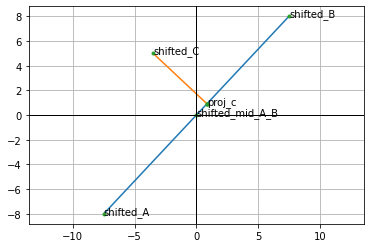

In [33]:
# Plot 
points = points + [proj_c]
labels = ['shifted_A', 'shifted_B', 'shifted_mid_A_B', 'shifted_C', 'proj_c']

points_x = [x[0] for x in points]
points_y = [x[1] for x in points]

aff_a, aff_b, aff_mid_a_b, aff_c = transformed_vecs

plt.plot([aff_a[0], aff_b[0]], [aff_a[1], aff_b[1]])
plt.plot([aff_c[0], proj_c[0]], [aff_c[1], proj_c[1]])

for coords, lbl in zip(points, labels):
    plt.text(coords[0], coords[1], lbl)

plt.plot(points_x, points_y, '.')
# Line
plt.grid()
plt.axhline(linewidth=1, color='black')
plt.axvline(linewidth=1, color='black')
plt.axis('equal')
plt.show()

## Rotation matrix 

In [92]:
# Finding angle between shifted_b and x axis
# https://www.cuemath.com/geometry/angle-between-vectors/
# https://math.stackexchange.com/questions/3325544/mathematical-notation-for-orthogonal-projection-of-a-set-of-points-on-a-line
vec_2 = np.array([[1], [0]])
mag_shifted_b = np.linalg.norm(aff_b)
mag_shifted_vec_2 = np.linalg.norm(vec_2)

cos_theta = (vec_2.T @ aff_b[:-1, ]) / (mag_shifted_b * mag_shifted_vec_2)
cos_theta = cos_theta[0, 0]

rotation_matrix = np.array([[cos_theta, 1], [1, cos_theta]])

rotation_matrix
# https://math.stackexchange.com/questions/1910825/how-do-i-find-the-angle-a-vector-makes-to-the-x-axis
# theta = np.cos(aff_b[0] / np.linalg.norm(aff_b - aff_mid_a_b)) ** -1
# np.degrees(theta)

array([[0.95831485, 1.        ],
       [1.        , 0.95831485]])

## Distance from a new point to the beggining of the axis

Next, we compute distance from a point to the begining of the aforementioned new axis.

In [9]:
# https://math.stackexchange.com/questions/1905533/find-perpendicular-distance-from-point-to-line-in-3d
# https://onlinemschool.com/math/library/analytic_geometry/p_line/
# https://www.nagwa.com/en/explainers/349153496801/
# https://softwareengineering.stackexchange.com/questions/168572/distance-from-point-to-n-dimensional-line

In [10]:
cucumber = nlp('cucumber')

<center>
$\overline{MC} = M - C $
<\center>

In [42]:
# mc_dist = mid - cucumber.vector

## Axis class

In [43]:
projection_dist = mc_dist @ direction

In [44]:
projection_dist

6.8615074

Rewriting all as a function

In [81]:
# https://math.stackexchange.com/questions/2397750/orthogonal-projection-of-point-onto-line-not-through-origin
# Affine transformation
class axis:
    
    def __init__(self, x, y):
        self.x = x 
        self.y = y
        self.mid = midpoint(x, y)
        self.direction = (x - self.mid) / np.linalg.norm(x - self.mid)
        
        self.pole_x = self(x)
        self.pole_y = self(y)
        
    def __call__(self, vec): 
        return (vec - self.mid) @ self.direction
    
    def project(self, vec):
        return self.mid - self(vec) * self.direction

In [82]:
## Simplified example in 2-dimensional space

In [83]:
# To discover potential bugs in the code we've written, 
# we make a simple experiment using a comprehensible example in 2-dimensional space.

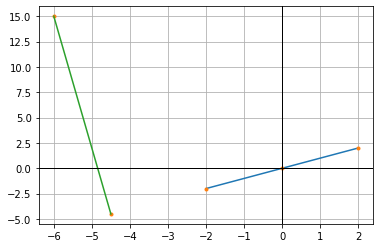

array([0., 0.])

In [87]:
# Points lying on the straight line
a = np.array([-10, 2])
b = np.array([5, 18])

# a = np.array([2, 2])
# b = np.array([-2, -2])

line_a_b = axis(a, b)
mid_a_b = line_a_b.mid

c = np.array([-6, 15])
proj_c = line_a_b.project(c)

points = [a, b, mid_a_b, c, proj_c]

points_x = [x[0] for x in points]
points_y = [x[1] for x in points]


plt.plot([a[0], b[0]], [a[1], b[1]])
plt.plot(points_x, points_y, '.')
# Line
plt.plot([c[0], proj_c[0]], [c[1], proj_c[1]], '-')
plt.grid()
plt.axhline(linewidth=1, color='black')
plt.axvline(linewidth=1, color='black')
plt.show()

mid_a_b

## Experiment with embeddings

In [75]:
ice_fire_axis = axis(ice.vector, fire.vector)

In [29]:
# Ice
ice_fire_axis.pole_x

# Fire
ice_fire_axis.pole_y

-4.104704

In [30]:
ice_fire_axis(nlp('icecream').vector)

1.5802484

In [31]:
ice_fire_axis(nlp('polar').vector)

1.3376285

In [32]:
axis(np.array([1, 2]), np.array([10, 2])).project(np.array([4, 5]))

array([4., 2.])

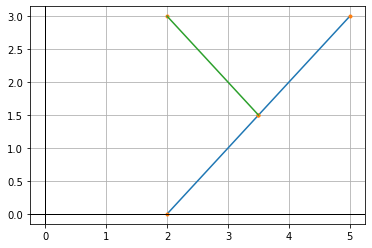

array([3.5, 1.5])

In [34]:
# a = np.array([1, 2])
# b = np.array([10, 2])
# c = np.array([4, 5])

a = np.array([2, 0])
b = np.array([5, 3])
c = np.array([2, 3])

line_a_b = axis(a, b)
mid_a_b = line_a_b.mid


proj_c = line_a_b.project(c)

points = [a, b, mid_a_b, c, proj_c]

points_x = [x[0] for x in points]
points_y = [x[1] for x in points]


plt.plot([a[0], b[0]], [a[1], b[1]])
plt.plot(points_x, points_y, '.')
# Line
plt.plot([c[0], proj_c[0]], [c[1], proj_c[1]], '-')
plt.grid()
plt.axhline(linewidth=1, color='black')
plt.axvline(linewidth=1, color='black')
plt.show()

proj_c

In [35]:
line_a_b.direction

array([-0.70710678, -0.70710678])

In [36]:
line_a_b.x - line_a_b.mid

array([-1.5, -1.5])

In [37]:
line_a_b.x 

array([2, 0])